In [1]:
import tensorflow as tf

from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display
import os 
from glob import glob


In [2]:

model=tf.saved_model.load('movenet_singlepose_thunder_4')
movenet = model.signatures['serving_default']

In [3]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,height, width,keypoint_threshold=0.11):
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
              kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
             interpolation=cv2.INTER_CUBIC)
    return image_from_plot



In [4]:
image_folders='Analysis/'

In [6]:
for image_folder in glob(image_folders+'/*'):
    for images_dire in glob(image_folder+'/*'):
        image=cv2.imread(images_dire)
        input_img=image.copy()
        input_img=cv2.resize(input_img,(256,256))
        input_img=np.array(input_img,dtype='int32')
        input_image = tf.cast(input_img, dtype=tf.int32)
        input_img=tf.convert_to_tensor(input_img)
        input_img=tf.expand_dims(input_img,axis=0)
        outputs=movenet(input_img)
        keypoints_with_scores = outputs['output_0'].numpy()
      
        display_image = tf.expand_dims(image, axis=0)
        display_image = tf.cast(tf.image.resize_with_pad(
            display_image, 540,960 ), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(
            np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
        
        new_path_folder='result/'+image_folder.replace('\\','/')
        if not os.path.exists(new_path_folder):
            os.makedirs(new_path_folder)
        img_path='result/'+images_dire.replace('\\','/')
        cv2.imwrite(img_path,output_overlay)

In [51]:
input_img=img.copy()
input_img=cv2.resize(input_img,(256,256))
input_img=np.array(input_img,dtype='int32')
input_image = tf.cast(input_img, dtype=tf.int32)
input_img=tf.convert_to_tensor(input_img)
input_img=tf.expand_dims(input_img,axis=0)
outputs=movenet(input_img)
keypoints_with_scores = outputs['output_0'].numpy()

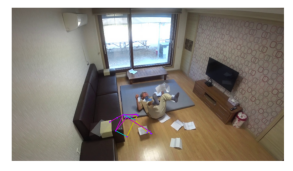

In [52]:
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 540, 960), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
output_overlay=cv2.cvtColor(output_overlay, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')


In [22]:
display_image.shape

TensorShape([1, 1280, 1280, 3])

In [23]:
image.shape

(540, 960, 3)